This Jupyter notebook was uploaded to the following github repository:

https://github.com/JohnOiko/Rock-Paper-Scissors-CNN

# 1. Import libraries

In [1]:
import cv2
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 2. Variables

## a. Preprocessing variables

In [2]:
random_state = 0
dataset_directory = '/content/drive/MyDrive/rps-cv-images'
height = 40
width = 60
grayscale = False
color_dim = 1 if grayscale else 3
vertical_flip_chance = 0.5
horizontal_flip_chance = 0.5
white_noise_mean = 0
white_noise_std = 0.05 * 255

## b. Game variables

In [3]:
rounds_num = 1000
victory_reward = 2
tie_reward = 1
loss_reward = -1
show_bad_predictions = True

# 3. Useful functions

## a. Function that distorts the given image

The image is first vertically flipped with the given chance, then horizontally flipped and then Gaussian noise is added to it, with the given mean and standard deviation.

In [4]:
def distort_image(img, vertical_flip_chance, horizontal_flip_chance, white_noise_mean, white_noise_std):
  distorted_img = img
  if random.random() < vertical_flip_chance:
    distorted_img = cv2.flip(distorted_img, 0)
  if random.random() < horizontal_flip_chance:
    distorted_img = cv2.flip(distorted_img, 1)

  distorted_img = distorted_img + np.random.normal(white_noise_mean, white_noise_std, np.shape(distorted_img))
  return distorted_img

## b. Function that hosts the game.

In [5]:
def playGame(images, real_labels, model, rounds_num, victory_reward, tie_reward, loss_reward, height, width, vertical_flip_chance, horizontal_flip_chance, white_noise_mean, white_noise_std, show_bad_predictions):
  # A table that holds the player's rewards based on the player's and random agent's moves.
  # The rows correspond to the player's moves and the columns to the random agent's moves.
  reward_table = np.array([[tie_reward, loss_reward, victory_reward], [victory_reward, tie_reward, loss_reward], [loss_reward, victory_reward, tie_reward]])

  profit = 0
  profit_history = []
  non_wins = 0
  for i in range(rounds_num):
    # Select a random image from the test set and reshape it back to its original dimensions.
    random_index = random.randint(0, len(images) - 1)
    selected_img = np.reshape(x_test[random_index], (height, width, color_dim))

    # Distort the image using the applicable function
    selected_distorted_img = distort_image(selected_img, vertical_flip_chance, horizontal_flip_chance, white_noise_mean, white_noise_std)

    # Scale the distorted image using min max scaling
    selected_distorted_scaled_img = selected_distorted_img / 255

    # Use the provided model to detect the move of the random agent.
    detected_move = np.argmax(model.predict(np.reshape(selected_distorted_scaled_img, (1, height, width, color_dim)), verbose=0))
    # Save the actual move of the random agent.
    real_move = real_labels[random_index]

    # Calculate the player's move based on the detected move. If the detected move was rock, play paper,
    # else if it was paper, play scissorcs, else if it was scissors, play rock.
    match detected_move:
      case 0:
        player_move = 1
        detected_move_label = 'rock'
      case 1:
        player_move = 2
        detected_move_label = 'paper'
      case 2:
        player_move = 0
        detected_move_label = 'scissors'

    # Update the total profit using the reward table.
    profit += reward_table[player_move, real_move] - 1

    # Add the current profit to the list of profits after the end of each round.
    profit_history.append(profit)

    if show_bad_predictions:
      match real_move:
        case 0:
          real_move_label = 'rock'
        case 1:
          real_move_label = 'paper'
        case 2:
          real_move_label = 'scissors'

      if reward_table[player_move, real_move] == tie_reward:
        non_wins += 1
        print(f'{non_wins}) Tied against this image (detected = {detected_move_label}, real = {real_move_label}):')
        cv2_imshow(selected_distorted_img)
      elif reward_table[player_move, real_move] == loss_reward:
        non_wins += 1
        print(f'{non_wins}) Lost against this image (detected = {detected_move_label}, real = {real_move_label}):')
        cv2_imshow(selected_distorted_img)

  return profit_history

# 4. Dataset reading

In [6]:
x, y = [], []
for folder in os.listdir(dataset_directory):
  for file in os.listdir(f'{dataset_directory}/{folder}'):
    # rock corresponds to the label 0, paper to 1 and scissors to 2.
    match folder:
      case 'rock': y.append(0)
      case 'paper':  y.append(1)
      case 'scissors': y.append(2)

    # Save the image.
    img = cv2.imread(f'{dataset_directory}/{folder}/{file}')
    # Resize the image to the selected dimensions.
    img = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)
    # If selected, save the image in grayscale.
    if grayscale:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Add the image to the list of images which will be saved in the dataframe
    x.append(img.flatten())

x, y = np.array(x), np.array(y)

# 5. Stratified train test split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)

# 6. Train and test sets distortion

In [8]:
x_train_dist_scaled = np.copy(x_train)
for i in range(len(x_train_dist_scaled)):
  x_train_dist_scaled[i] = distort_image(np.reshape(x_train_dist_scaled[i], (height, width, color_dim)), vertical_flip_chance, horizontal_flip_chance, white_noise_mean, white_noise_std).flatten()

In [9]:
x_test_dist_scaled = np.copy(x_test)
for i in range(len(x_test_dist_scaled)):
  x_test_dist_scaled[i] = distort_image(np.reshape(x_test_dist_scaled[i], (height, width, color_dim)), vertical_flip_chance, horizontal_flip_chance, white_noise_mean, white_noise_std).flatten()

# 7. Min max scaling

In [10]:
scaler = MinMaxScaler()
x_train_dist_norm = scaler.fit_transform(x_train_dist_scaled)

In [11]:
x_test_dist_norm = scaler.transform(x_test_dist_scaled)

# 8 Train different models to predict the move each image depicts

The SVC and Random Forest are trained using the distorted train set. The Keras convolutional NN has two flip layers (one vertical and one horizontal) and one gaussian noise one.

## SVC fitting and classification reports

In [12]:
svc = SVC(random_state=random_state)
svc.fit(x_train_dist_scaled, y_train)

print(f'SVC train classification report:\n{classification_report(y_train, svc.predict(x_train_dist_scaled), target_names=["rock", "paper", "scissors"])}')
print(f'SVC test classification report:\n{classification_report(y_test, svc.predict(x_test_dist_scaled), target_names=["rock", "paper", "scissors"])}')

Train classification report:
              precision    recall  f1-score   support

        rock       0.99      0.96      0.97       581
       paper       0.99      0.95      0.97       569
    scissors       0.93      0.99      0.96       600

    accuracy                           0.97      1750
   macro avg       0.97      0.97      0.97      1750
weighted avg       0.97      0.97      0.97      1750

Test classification report:
              precision    recall  f1-score   support

        rock       0.95      0.92      0.93       145
       paper       0.96      0.88      0.92       143
    scissors       0.87      0.97      0.91       150

    accuracy                           0.92       438
   macro avg       0.93      0.92      0.92       438
weighted avg       0.93      0.92      0.92       438



## Random forest fitting and classfication reports

In [13]:
rf = RandomForestClassifier(random_state=random_state)
rf.fit(x_train_dist_scaled, y_train)

print(f'RF train classification report:\n{classification_report(y_train, rf.predict(x_train_dist_scaled), target_names=["rock", "paper", "scissors"])}')
print(f'RF test classification report:\n{classification_report(y_test, rf.predict(x_test_dist_scaled), target_names=["rock", "paper", "scissors"])}')

Train classification report:
              precision    recall  f1-score   support

        rock       1.00      1.00      1.00       581
       paper       1.00      1.00      1.00       569
    scissors       1.00      1.00      1.00       600

    accuracy                           1.00      1750
   macro avg       1.00      1.00      1.00      1750
weighted avg       1.00      1.00      1.00      1750

Test classification report:
              precision    recall  f1-score   support

        rock       0.87      0.94      0.90       145
       paper       0.92      0.84      0.88       143
    scissors       0.91      0.92      0.91       150

    accuracy                           0.90       438
   macro avg       0.90      0.90      0.90       438
weighted avg       0.90      0.90      0.90       438



## Convolutional neural network fitting and classification reports

Reshape the train and test sets back to thier original shape and scale them using min max scaling.

In [14]:
x_train_cnn = np.reshape(np.array(x_train), (x_train.shape[0], height, width, color_dim)) / 255
x_test_cnn = np.reshape(np.array(x_test), (x_test.shape[0], height, width, color_dim)) / 255

There are three classes and the labels are one-hot encoded.

In [15]:
num_classes = 3
y_train_one_hot = tf.one_hot(y_train, depth=num_classes)
y_test_one_hot = tf.one_hot(y_test, depth=num_classes)
y_train.shape, y_test.shape

((1750,), (438,))

Keras convolutional neural network parameters.

In [16]:
num_conv_layers = 2
num_filters = 64
kernel_size = (4, 6)
strides = (1, 1)
input_shape = (height, width, )
num_hidden_layers = 5
units = [98, 196, 392, 196, 98]

activation = 'relu'
dropout_rate = 0.5

In [17]:
cnn = tf.keras.Sequential(name='rock-paper-scissorcs-cn')

# Flip and Gaussian noise layers
cnn.add(tf.keras.layers.Input((height, width, color_dim), name='input_layer'))
cnn.add(tf.keras.layers.RandomFlip(mode='vertical'))
cnn.add(tf.keras.layers.RandomFlip(mode='horizontal'))
cnn.add(tf.keras.layers.GaussianNoise(stddev=white_noise_std / 255))

# CNN
for i in range(num_conv_layers):
  cnn.add(
      tf.keras.layers.Conv2D(
          filters=num_filters,
          kernel_size=kernel_size,
          strides=strides,
          activation='relu',
          name=f'conv_layer_{i+1}'
      )
  )
  cnn.add(tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout_{i+1}'))
  cnn.add(tf.keras.layers.MaxPooling2D(name=f'maxpool_{i+1}'))

# Flattening
cnn.add(tf.keras.layers.Flatten())

# CNN
for i in range(num_hidden_layers):
  cnn.add(tf.keras.layers.Dense(units=units[i], activation=activation, name=f'hidden_layer_{i+1}'))
cnn.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', name='output_layer'))
cnn.summary()

Model: "rock-paper-scissorcs-cn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 40, 60, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 40, 60, 3)         0         
                                                                 
 gaussian_noise (GaussianNo  (None, 40, 60, 3)         0         
 ise)                                                            
                                                                 
 conv_layer_1 (Conv2D)       (None, 37, 55, 64)        4672      
                                                                 
 dropout_1 (Dropout)         (None, 37, 55, 64)        0         
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 18, 27, 64)        0         
                                           

In [18]:
learning_rate = 0.0002
loss = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 256
epochs = 70

cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=metrics)
cnn.fit(x_train_cnn, y_train_one_hot, batch_size=batch_size, epochs=epochs)

Epoch 1/75
7/7 [==============================] - 19s 2s/step - loss: 1.0888 - accuracy: 0.3983
Epoch 2/75
7/7 [==============================] - 16s 2s/step - loss: 1.0101 - accuracy: 0.5503
Epoch 3/75
7/7 [==============================] - 20s 3s/step - loss: 0.8971 - accuracy: 0.6160
Epoch 4/75
7/7 [==============================] - 17s 2s/step - loss: 0.7819 - accuracy: 0.6874
Epoch 5/75
7/7 [==============================] - 16s 2s/step - loss: 0.6549 - accuracy: 0.7326
Epoch 6/75
7/7 [==============================] - 16s 2s/step - loss: 0.5554 - accuracy: 0.7783
Epoch 7/75
7/7 [==============================] - 16s 2s/step - loss: 0.4984 - accuracy: 0.7954
Epoch 8/75
7/7 [==============================] - 17s 2s/step - loss: 0.4249 - accuracy: 0.8274
Epoch 9/75
7/7 [==============================] - 16s 2s/step - loss: 0.3704 - accuracy: 0.8583
Epoch 10/75
7/7 [==============================] - 17s 2s/step - loss: 0.3034 - accuracy: 0.8920
Epoch 11/75
7/7 [======================

In [19]:
print(f'CNN train classification report:\n{classification_report(y_train, np.argmax(cnn.predict(x_train_cnn), axis=1), target_names=["rock", "paper", "scissors"])}')
print(f'CNN test classification report:\n{classification_report(y_test, np.argmax(cnn.predict(x_test_cnn), axis=1), target_names=["rock", "paper", "scissors"])}')

55/55 [==============================] - 3s 55ms/step
Train classification report:
              precision    recall  f1-score   support

        rock       1.00      1.00      1.00       581
       paper       1.00      1.00      1.00       569
    scissors       1.00      1.00      1.00       600

    accuracy                           1.00      1750
   macro avg       1.00      1.00      1.00      1750
weighted avg       1.00      1.00      1.00      1750

14/14 [==============================] - 1s 53ms/step
Test classification report:
              precision    recall  f1-score   support

        rock       0.99      0.99      0.99       145
       paper       0.98      0.98      0.98       143
    scissors       0.99      0.99      0.99       150

    accuracy                           0.99       438
   macro avg       0.99      0.99      0.99       438
weighted avg       0.99      0.99      0.99       438



# 9. Game simulation

1) Tied against this image (detected = rock, real = paper):


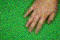

2) Lost against this image (detected = paper, real = rock):


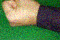

3) Tied against this image (detected = paper, real = scissors):


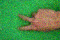

4) Tied against this image (detected = rock, real = paper):


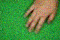

5) Tied against this image (detected = rock, real = paper):


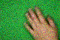

6) Lost against this image (detected = paper, real = rock):


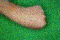

7) Lost against this image (detected = paper, real = rock):


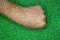

8) Lost against this image (detected = paper, real = rock):


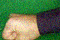

9) Lost against this image (detected = paper, real = rock):


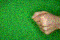

10) Lost against this image (detected = paper, real = rock):


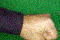

11) Tied against this image (detected = rock, real = paper):


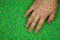

12) Tied against this image (detected = rock, real = paper):


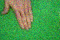

13) Lost against this image (detected = paper, real = rock):


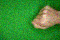

14) Tied against this image (detected = rock, real = paper):


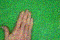

15) Lost against this image (detected = paper, real = rock):


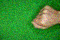

16) Lost against this image (detected = paper, real = rock):


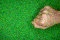

17) Lost against this image (detected = paper, real = rock):


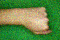

18) Lost against this image (detected = scissors, real = paper):


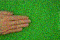

19) Lost against this image (detected = scissors, real = paper):


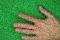

20) Lost against this image (detected = paper, real = rock):


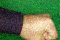

21) Tied against this image (detected = rock, real = paper):


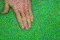

22) Tied against this image (detected = paper, real = scissors):


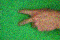


The total profit is 952


In [20]:
profit_history = playGame(x_test, y_test, cnn, rounds_num, victory_reward, tie_reward, loss_reward, height, width, vertical_flip_chance, horizontal_flip_chance, white_noise_mean, white_noise_std, show_bad_predictions)
print(f'\nThe total profit is {profit_history[-1]}')

# 10. Total profit plot

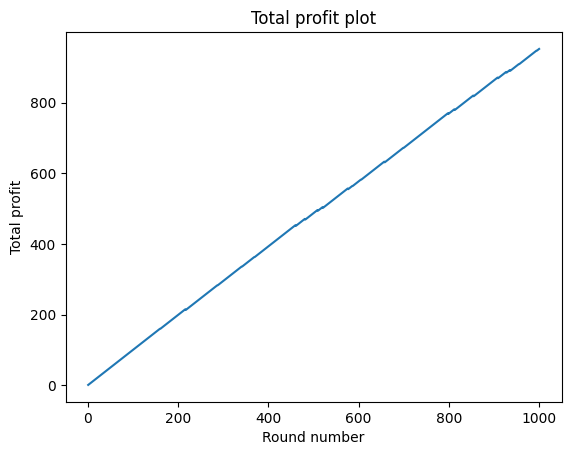

In [21]:
plot = plt.plot([i for i in range(1, rounds_num + 1)], profit_history)
plt.xlabel("Round number")
plt.ylabel("Total profit")
plt.title("Total profit plot")
plt.show()

# 11. Secondary dataset classification report

Secondary dataset reading (only 500 samples from each class are used).

In [22]:
x_sec, y_sec = [], []
secondary_dataset_directory = '/content/drive/MyDrive/secondary-rps-images'
for folder in os.listdir(secondary_dataset_directory):
  for file in os.listdir(f'{secondary_dataset_directory}/{folder}'):
    # rock corresponds to the label 0, paper to 1 and scissors to 2.
    match folder:
      case 'rock': y_sec.append(0)
      case 'paper':  y_sec.append(1)
      case 'scissors': y_sec.append(2)

    # Save the image.
    img = cv2.imread(f'{secondary_dataset_directory}/{folder}/{file}')
    # Resize the image to the selected dimensions.
    img = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)
    # If selected, save the image in grayscale.
    if grayscale:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Add the image to the list of images which will be saved in the dataframe
    x_sec.append(img)

x_sec, y_sec = np.array(x_sec) / 255, np.array(y_sec)

Classification report of the CNN on the secondary dataset.

In [23]:
print(f'Secondary dataset classification report:\n{classification_report(y_sec, np.argmax(cnn.predict(x_sec), axis=1), target_names=["rock", "paper", "scissors"], zero_division=0.0)}')

47/47 [==============================] - 3s 55ms/step
Secondary dataset classification report:
              precision    recall  f1-score   support

        rock       1.00      0.07      0.14       500
       paper       0.34      1.00      0.51       500
    scissors       0.00      0.00      0.00       500

    accuracy                           0.36      1500
   macro avg       0.45      0.36      0.22      1500
weighted avg       0.45      0.36      0.22      1500

